# Classificator (VAE and NN are split)
This notebook aims to train a VAE + NN configuration to classify datapoints according to a label. The label is given according to values of ratio, which is computed as (solar + wind + hydro) / load (effective data, not detrended nor normalized).

To achieve this a VAE + NN configuration is going to be trained. VAE will have as inputs the meteo forecast data. Its performance will be judged according to its loss function, its ability to recreate the inputs and to make a comprehensive latent space, in which different classified points are scattered in different (as far as possible) clusters.

The NN takes in input the latent space vectors from the VAE (and some extra features, referring to the installations) and performs the real classification. The aim of VAE is then to reduce the dimensionality while keeping the records as informative as possible. 

NN and VAE are trained separately in this notebook: VAE is trained first, then it is frozen and it is used only to generate the latent vectors starting from input data. The NN is trained later on these data points.

# 0: Importing libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import os
from itertools import product
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F

# zone selection
sel_zone = 'IT_SICI'
# make directory for saving screenshots
directory_name = f'3_plots/{sel_zone}'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory '3_plots/IT_SICI' already exists.


# 1: Data import and handling
### 1.1: VAE Inputs
For meteo forecast data, we are taking a 24h time window (each record will keep only the 24h previous data, instead of 48h)

In [2]:
# df_features contains meteo forecast data
df_features = pd.read_csv(f'1_output/{sel_zone}_meteo_forecast_data.csv') # vae training (input features X)

# keeping only the right columns
# 1 is unnamed (useless), 14 * 8 are the columns referring to the day before yesterday
sel_cols = df_features.columns[(1 + 14 * 8):]
df_features = df_features[sel_cols]
df_features

year_t-8    2t_t-8  solar_t-8    tp_t-8  ws_10m_t-8  ws_100m_t-8  \
0    -1.226619 -0.999569  -0.840435 -0.342050   -0.190969     0.154323   
1    -1.226619 -1.108632  -0.840435 -0.342050   -0.335500    -0.074293   
2    -1.226619 -1.080245  -0.840435 -0.342050   -0.336900    -0.173302   
3    -1.226619 -1.184618  -0.528573 -0.346102   -0.509806    -0.482090   
4    -1.226619 -0.448096   0.732464 -0.346102   -0.901648    -0.893205   
...        ...       ...        ...       ...         ...          ...   
8009  1.223256 -0.489875  -0.505796 -0.347858   -1.218322    -1.093061   
8010  1.223256 -1.087249  -0.840435 -0.348566   -1.314220    -1.271296   
8011  1.223256 -1.087249  -0.840435 -0.348566   -1.314220    -1.271296   
8012  1.223256 -1.397997  -0.840435 -0.348566   -1.437685    -1.503530   
8013  1.223256 -1.567490  -0.840435 -0.348566   -1.256009    -1.211118   

      hour_sin_t-8  hour_cos_t-8  day_sin_t-8  day_cos_t-8  ...  ws_100m_t-0  \
0        -0.658723      1.520181     0.271618     1.406185  ...    -0.830994   
1         0.271809      2.018651     0.543231     1.320060  ...    -0.647086   
2         1.202341      1.520181     0.543231     1.320060  ...    -0.889436   
3         1.587780      0.316766     0.543231     1.320060  ...    -0.229640   
4         1.202341     -0.886649     0.543231     1.320060  ...    -0.155538   
...            ...           ...          ...          ...  ...          ...   
8009     -0.658723     -0.886649    -0.294798     1.406185  ...    -1.288231   
8010     -1.044162      0.316766    -0.294798     1.406185  ...    -0.856499   
8011     -1.044162      0.316766    -0.294798     1.406185  ...    -0.966367   
8012     -0.658723      1.520181    -0.294798     1.406185  ...    -0.966367   
8013      0.271809      2.018651    -0.011590     1.435291  ...    -1.019740   

      hour_sin_t-0  hour_cos_t-0  day_sin_t-0  day_cos_t-0  month_sin_t-0  \
0        -1.043931      0.317057     0.543823     1.319766       0.703664   
1        -0.658517      1.520770     0.543823     1.319766       0.703664   
2         0.271956      2.019364     0.792755     1.180167       0.703664   
3         1.202429      1.520770     0.792755     1.180167       0.703664   
4         1.587843      0.317057     0.792755     1.180167       0.703664   
...            ...           ...          ...          ...            ...   
8009      0.271956     -1.385250    -0.011072     1.434980      -0.017855   
8010     -0.658517     -0.886656    -0.011072     1.434980      -0.017855   
8011     -1.043931      0.317057    -0.011072     1.434980      -0.017855   
8012     -1.043931      0.317057    -0.011072     1.434980      -0.017855   
8013     -0.658517      1.520770    -0.011072     1.434980      -0.017855   

      month_cos_t-0  sin_dayofyear_t-0  cos_dayofyear_t-0            timestamp  
0          1.139761           0.043675           1.315580  2022-01-02 18:00:00  
1          1.139761           0.043675           1.315580  2022-01-02 21:00:00  
2          1.139761           0.068559           1.314552  2022-01-03 00:00:00  
3          1.139761           0.068559           1.314552  2022-01-03 03:00:00  
4          1.139761           0.068559           1.314552  2022-01-03 06:00:00  
...             ...                ...                ...                  ...  
8009       1.326000          -0.006130           1.316402  2024-12-31 12:00:00  
8010       1.326000          -0.006130           1.316402  2024-12-31 15:00:00  
8011       1.326000          -0.006130           1.316402  2024-12-31 18:00:00  
8012       1.326000          -0.006130           1.316402  2024-12-31 18:00:00  
8013       1.326000          -0.006130           1.316402  2024-12-31 21:00:00  

[8014 rows x 127 columns]

### 1.2: NN inputs and classification labels
This dataframe contains detrended solar, detrended wind and detrended hydro that can be used to perform a regression. Here we are interested on the "installed" columns, which will be given to the NN as extra inputs, and to "ratio" column, which will be our label for classification

In [3]:
df_labels = pd.read_csv(f'2_outputs/{sel_zone}_installation_detrended_actuals.csv') # regression training/test
df_labels

date_time  solar   wind  hydro  generation    load  \
0      2022-01-01 00:00:00+00:00    0.0  368.0   34.0      1042.0  1599.0   
1      2022-01-01 01:00:00+00:00    0.0  330.0   34.0      1043.0  1478.0   
2      2022-01-01 02:00:00+00:00    0.0  292.0   33.0       987.0  1374.0   
3      2022-01-01 03:00:00+00:00    0.0  333.0   34.0       922.0  1305.0   
4      2022-01-01 04:00:00+00:00    0.0  379.0   33.0       958.0  1299.0   
...                          ...    ...    ...    ...         ...     ...   
26260  2024-12-30 19:00:00+00:00    0.0    5.0    9.0      1427.0  2452.0   
26261  2024-12-30 20:00:00+00:00    0.0    5.0    9.0      1285.0  2302.0   
26262  2024-12-30 21:00:00+00:00    0.0    5.0    9.0      1097.0  2110.0   
26263  2024-12-30 22:00:00+00:00    0.0    6.0    8.0      1000.0  1869.0   
26264  2024-12-30 23:00:00+00:00    0.0   17.0    7.0       722.0  1669.0   

           time  solar_installed  hydro_installed  wind_installed  \
0      0.000000      1541.226150            152.0     2007.833333   
1      0.000038      1541.241037            152.0     2007.848345   
2      0.000076      1541.255927            152.0     2007.863357   
3      0.000114      1541.270820            152.0     2007.878369   
4      0.000152      1541.285714            152.0     2007.893381   
...         ...              ...              ...             ...   
26260  0.999848      2634.917096            152.0     2432.395368   
26261  0.999886      2634.974471            152.0     2432.412842   
26262  0.999924      2635.031847            152.0     2432.430317   
26263  0.999962      2635.089223            152.0     2432.447791   
26264  1.000000      2635.146599            152.0     2432.465265   

       detrended_solar  detrended_wind  detrended_hydro     ratio  
0                  0.0        0.183282         0.223684  0.251407  
1                  0.0        0.164355         0.223684  0.246279  
2                  0.0        0.145428         0.217105  0.236536  
3                  0.0        0.165847         0.223684  0.281226  
4                  0.0        0.188755         0.217105  0.317167  
...                ...             ...              ...       ...  
26260              0.0        0.002056         0.059211  0.005710  
26261              0.0        0.002056         0.059211  0.006082  
26262              0.0        0.002056         0.059211  0.006635  
26263              0.0        0.002467         0.052632  0.007491  
26264              0.0        0.006989         0.046053  0.014380  

[26265 rows x 14 columns]

This data must be grouped in 3h timestamps. If the window of 3h cannot be completed (datapoints missing/discarded because were outliers) the datapoints are discarded.

In [4]:
# remove timezone information
df_labels['date_time'] = pd.to_datetime(df_labels['date_time'], utc= True).dt.tz_convert(None)
# sort by date
df_labels = df_labels.sort_values('date_time')
df_labels = df_labels.set_index('date_time')

# resample every 3h with no overlapping windows and keeping the first timestamp as index
start_time = df_labels.index[0]
groups = []
# Define which columns to sum and which to average
sum_columns = ['solar','wind','hydro','load','detrended_solar','detrended_wind','detrended_hydro']
mean_columns = ['ratio','solar_installed','wind_installed','hydro_installed']  # example

groups = []
start_time = df_labels.index[0]

while start_time + pd.Timedelta(hours=3) <= df_labels.index[-1] + pd.Timedelta(minutes=1):
    end_time = start_time + pd.Timedelta(hours=3)
    chunk = df_labels[start_time:end_time - pd.Timedelta(seconds=1)]

    if len(chunk) == 3 and all((chunk.index == [start_time + pd.Timedelta(hours=i) for i in range(3)])):
        summed = chunk[sum_columns].sum()
        averaged = chunk[mean_columns].mean()
        
        combined = pd.concat([summed, averaged])
        combined.name = start_time
        groups.append(combined)

    start_time += pd.Timedelta(hours=3)

# retrieve date time info
result_df = pd.DataFrame(groups).reset_index().rename(columns={'index': 'date_time'})
result_df

date_time   solar    wind  hydro    load  detrended_solar  \
0    2022-01-01 00:00:00     0.0   990.0  101.0  4451.0         0.000000   
1    2022-01-01 03:00:00     0.0  1109.0  101.0  3934.0         0.000000   
2    2022-01-01 06:00:00   633.0  1542.0   98.0  4518.0         0.410682   
3    2022-01-01 09:00:00  1572.0  1140.0   97.0  5573.0         1.019868   
4    2022-01-01 12:00:00  1182.0  1477.0   98.0  5079.0         0.766827   
...                  ...     ...     ...    ...     ...              ...   
8744 2024-12-30 06:00:00  1147.0    15.0   27.0  5907.0         0.435416   
8745 2024-12-30 09:00:00  2900.0    15.0   27.0  6008.0         1.100819   
8746 2024-12-30 12:00:00  2034.0    17.0   27.0  5877.0         0.772046   
8747 2024-12-30 15:00:00    61.0    30.0   27.0  6917.0         0.023153   
8748 2024-12-30 18:00:00     0.0    17.0   27.0  7228.0         0.000000   

      detrended_wind  detrended_hydro     ratio  solar_installed  \
0           0.493065         0.664474  0.244741      1541.241038   
1           0.552320         0.664474  0.307484      1541.285715   
2           0.767952         0.644737  0.495725      1541.330412   
3           0.567734         0.638158  0.504510      1541.375131   
4           0.735547         0.644737  0.541952      1541.419869   
...              ...              ...       ...              ...   
8744        0.006167         0.177632  0.191808      2634.228585   
8745        0.006167         0.177632  0.490237      2634.400713   
8746        0.006989         0.177632  0.355393      2634.572840   
8747        0.012334         0.177632  0.017682      2634.744968   
8748        0.006989         0.177632  0.006086      2634.917096   

      wind_installed  hydro_installed  
0        2007.848345            152.0  
1        2007.893381            152.0  
2        2007.938417            152.0  
3        2007.983453            152.0  
4        2008.028489            152.0  
...              ...              ...  
8744     2432.185680            152.0  
8745     2432.238102            152.0  
8746     2432.290524            152.0  
8747     2432.342946            152.0  
8748     2432.395368            152.0  

[8749 rows x 12 columns]

### 1.2.1 Rescaling features accordingly
For classification purposes, we want to use the installed data as input for our NN. Ratio is our desired label and does not need to be rescaled.

In [5]:
df_labels = result_df[['solar_installed','hydro_installed','wind_installed']]
ratio = result_df[['ratio']]
df_labels_datetime = result_df[['date_time']]

# rescale the installation features
installation_scaler = StandardScaler()
installation_scaler.fit(df_labels.values)
scaled_labels = installation_scaler.transform(df_labels.values)

# merge the frames
df_labels_rescaled = pd.DataFrame({
    'scaled_solar_installed':scaled_labels[:,0],
    'scaled_hydro_installed':scaled_labels[:,1],
    'scaled_wind_installed':scaled_labels[:,2],
    'ratio':ratio.values.flatten(),
    'date_time':df_labels_datetime.values.flatten()
})
df_labels_rescaled

scaled_solar_installed  scaled_hydro_installed  scaled_wind_installed  \
0                  -1.362830           -5.684342e-14              -1.666489   
1                  -1.362693           -5.684342e-14              -1.666120   
2                  -1.362557           -5.684342e-14              -1.665751   
3                  -1.362421           -5.684342e-14              -1.665382   
4                  -1.362284           -5.684342e-14              -1.665013   
...                      ...                     ...                    ...   
8744                1.973598            2.842171e-14               1.810650   
8745                1.974123            2.842171e-14               1.811079   
8746                1.974648            2.842171e-14               1.811509   
8747                1.975174            2.842171e-14               1.811939   
8748                1.975699            2.842171e-14               1.812368   

         ratio           date_time  
0     0.244741 2022-01-01 00:00:00  
1     0.307484 2022-01-01 03:00:00  
2     0.495725 2022-01-01 06:00:00  
3     0.504510 2022-01-01 09:00:00  
4     0.541952 2022-01-01 12:00:00  
...        ...                 ...  
8744  0.191808 2024-12-30 06:00:00  
8745  0.490237 2024-12-30 09:00:00  
8746  0.355393 2024-12-30 12:00:00  
8747  0.017682 2024-12-30 15:00:00  
8748  0.006086 2024-12-30 18:00:00  

[8749 rows x 5 columns]

### 1.3: Joining dataframes 
We want to keep only the points that are common to both dataframes. An inner join will do the job.

The number of records that is kept after this step depends on the geographical zone, since we dropped some outliers from the dataset and don't know if there were correspondances in different zones/databases.

In [6]:
# keeping only the ones in common
df_labels_rescaled['date_time'] = pd.to_datetime(df_labels_rescaled['date_time']).dt.tz_localize(None)
df_features['date_time'] = pd.to_datetime(df_features['timestamp']).dt.tz_localize(None)
common = pd.merge(df_features, df_labels_rescaled, on='date_time', how = 'inner')
df_labels = common[df_labels_rescaled.columns]
df_features = common[df_features.columns]
print(np.shape(df_features),np.shape(df_labels))


(7994, 128) (7994, 5)


## 1.4: showing that PCA is not enough
One could observe that this way the VAE is used to perform an operation that a PCA would do in easier settings. We can check how much variance of our dataset is explained by a relatively small number of features and observe wheter this is true or not

shape of input: (7994, 126)


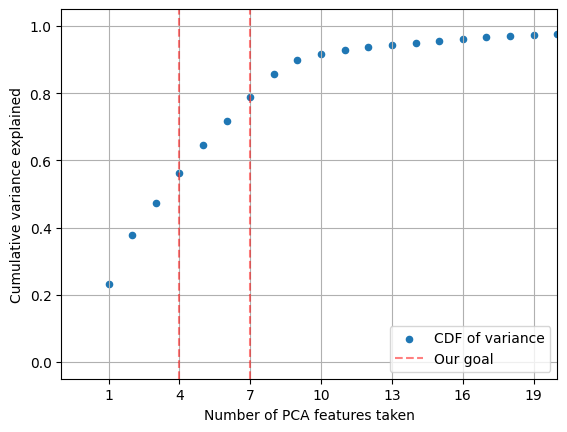

In [7]:
to_transform = df_features.drop(columns = ['date_time','timestamp'])
pca = PCA(n_components = np.shape(to_transform)[1])
transformed = pca.fit_transform(to_transform.values)
cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)

print('shape of input:',np.shape(to_transform))
plt.scatter(np.arange(1,len(cumulative_ratio)+1,1),cumulative_ratio, s = 20, label = 'CDF of variance')
plt.axvline(x = 4, color = 'red', ls = '--',label = 'Our goal', alpha = 0.5)
plt.axvline(x = 7, color = 'red', ls = '--', alpha = 0.5)
plt.xticks(np.arange(1,len(cumulative_ratio)+1,3))
plt.xlim(-1,20)
plt.ylim(-0.05,1.05)
plt.xlabel('Number of PCA features taken')
plt.ylabel('Cumulative variance explained')
plt.grid()
plt.legend()

filename = f'{directory_name}/part1.3_pca.png'
plt.savefig(filename)
plt.show()

## 1.5 Setting up classes
Seen that we need VAE to retrieve more informative features, we have to decide how to setup the classes for the classification. We plot an histogram of ratio, and a cdf of ratio to see where to put a reasonable cutoff value.

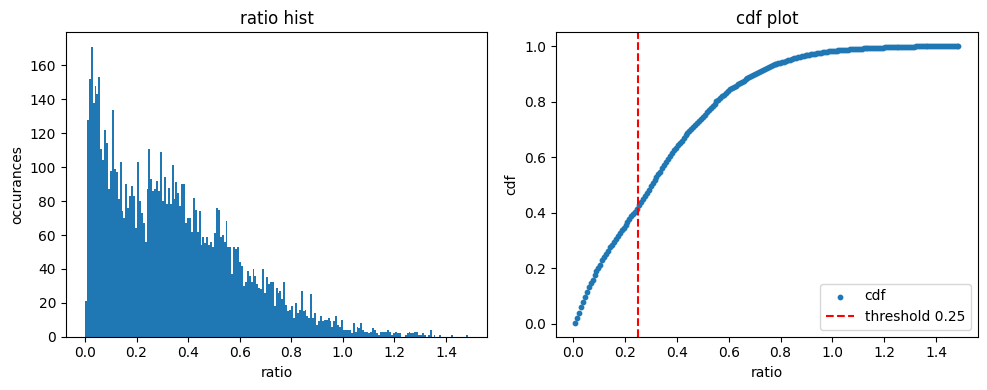

In [8]:
nbins = 200
thresholds = [0.25]

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 
hist = ax[0].hist(df_labels['ratio'], bins = np.linspace(0,max(df_labels['ratio']),nbins))
ax[0].set_xlabel('ratio')
ax[0].set_ylabel('occurances')
ax[0].set_title('ratio hist')

freq = hist[0]
cdf = np.cumsum(freq)
cdf = cdf / max(cdf)
x_axis = np.linspace(0,max(df_labels['ratio']),nbins)
x_axis = x_axis[1:]
ax[1].scatter(x_axis, cdf, s = 10, label = 'cdf')
ax[1].set_xlabel('ratio')
ax[1].set_ylabel('cdf')
ax[1].set_title('cdf plot')

for threshold in thresholds:
    ax[1].axvline(x=threshold, color='r', linestyle='--', label =f'threshold {threshold}')
ax[1].legend()

plt.tight_layout()
filename = f'{directory_name}/part1.4_ratio_hist_cdf.png'
plt.savefig(filename)
plt.show()

Looking at the distribution, it is reasonable to split at 1 (to have a meaningful physical information)

In [9]:
class_idx = 0
new_thresholds = [0] + thresholds + [max(df_labels['ratio'])]

df_labels['class'] = np.zeros(len(df_labels.index))

print('class intervals:',new_thresholds)
# Assign class based on interval
for i in range(len(new_thresholds) - 1):
    mask = (df_labels['ratio'] > new_thresholds[i]) & (df_labels['ratio'] <= new_thresholds[i + 1])
    df_labels.loc[mask, 'class'] = class_idx
    class_idx += 1

# Check number of datapoints in each class
all_classes = np.unique(df_labels['class'])
tot = len(df_labels['class'])

for class_ in all_classes:
    occ = np.sum(df_labels['class'] == class_)
    print(f'class {int(class_)} occurs {occ} times: {occ/tot:.2%}')


class intervals: [0, 0.25, 1.4860588025448445]
class 0 occurs 3347 times: 41.87%
class 1 occurs 4647 times: 58.13%


/tmp/ipykernel_51067/1236615827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['class'] = np.zeros(len(df_labels.index))


### 1.6 Removing redundant time information

In meteo forecast data, both (day, month) and dayoftheyear represent the same time information. We pick one to remove and keep sin and cos of the other. In the code dayoftheyear is implemented

In [10]:
# keeping only dayofthe year
df = df_features
features = ['day_sin_t-0','day_cos_t-0',
           'day_sin_t-1','day_cos_t-1',
           'day_sin_t-2','day_cos_t-2',
           'day_sin_t-3','day_cos_t-3',
           'day_sin_t-4','day_cos_t-4',
           'day_sin_t-5','day_cos_t-5',
           'day_sin_t-6','day_cos_t-6',
           'day_sin_t-7','day_cos_t-7',
           'day_sin_t-8','day_cos_t-8',
           'month_sin_t-0','month_cos_t-0',
           'month_sin_t-1','month_cos_t-1',
           'month_sin_t-2','month_cos_t-2',
           'month_sin_t-3','month_cos_t-3',
           'month_sin_t-4','month_cos_t-4',
           'month_sin_t-5','month_cos_t-5',
           'month_sin_t-6','month_cos_t-6',
           'month_sin_t-7','month_cos_t-7',
           'month_sin_t-8','month_cos_t-8']

# in alternative one can use the following lines to keep day and month
'''
features = ['sin_dayofyear_t0','cos_dayofyear_t0',
            'sin_dayofyear_t1','cos_dayofyear_t1',
            'sin_dayofyear_t2','cos_dayofyear_t2',
            'sin_dayofyear_t3','cos_dayofyear_t3',
            'sin_dayofyear_t4','cos_dayofyear_t4',
            'sin_dayofyear_t5','cos_dayofyear_t5',
            'sin_dayofyear_t6','cos_dayofyear_t6',
            'sin_dayofyear_t7','cos_dayofyear_t7',
            'sin_dayofyear_t8','cos_dayofyear_t8'
            ]
'''

df = df.drop(columns = features)
timestamp = pd.to_datetime(df['timestamp'])

timestamp_backup = timestamp.copy()

################################################
# SOFIA
# questo vettore (timestamp) è quello che puoi usare per colorare diversamente i punti secondo un certo criterio
# al momento sta usando i dati di produzione di noemi (quelli un po' scrausi)
# se vuoi vedere cosa succede per le diverse stagioni puoi provare a cambiare con queste righe:
#timestamp = timestamp.dt.hour
#timestamp = [1 if x in [1,2,3] else 2 if x in [4,5,6] else 3 if x in [7,8,9] else 4 if x in [10,11,12] for x in timestamp]

timestamp = df_labels['class']
# una volta che hai buttato dentro quello che vuoi fai andare il codice (se non va fai andare anche la cella
# sopra che c'è un drop qui)
##################################################
# to save indexes for plotting later
timestamp_tensor = torch.tensor(timestamp, dtype = torch.float32)  # Encodes strings to integers

df.drop('timestamp', axis=1, inplace=True)

print("Input Dataframe Dim:", df.shape)
df


Input Dataframe Dim: (7994, 91)


year_t-8    2t_t-8  solar_t-8    tp_t-8  ws_10m_t-8  ws_100m_t-8  \
0    -1.226619 -0.999569  -0.840435 -0.342050   -0.190969     0.154323   
1    -1.226619 -1.108632  -0.840435 -0.342050   -0.335500    -0.074293   
2    -1.226619 -1.080245  -0.840435 -0.342050   -0.336900    -0.173302   
3    -1.226619 -1.184618  -0.528573 -0.346102   -0.509806    -0.482090   
4    -1.226619 -0.448096   0.732464 -0.346102   -0.901648    -0.893205   
...        ...       ...        ...       ...         ...          ...   
7989  1.223256 -0.514274   0.434372 -0.324732   -0.793738    -0.949911   
7990  1.223256 -0.569182  -0.559709 -0.324732   -1.080105    -0.937567   
7991  1.223256 -1.073027  -0.840435 -0.349128   -1.088258    -1.033064   
7992  1.223256 -1.073027  -0.840435 -0.349128   -1.088258    -1.033064   
7993  1.223256 -1.323396  -0.840435 -0.349128   -1.192893    -1.182448   

      hour_sin_t-8  hour_cos_t-8  sin_dayofyear_t-8  cos_dayofyear_t-8  ...  \
0        -0.658723      1.520181           0.018730           1.316198  ...   
1         0.271809      2.018651           0.043629           1.315582  ...   
2         1.202341      1.520181           0.043629           1.315582  ...   
3         1.587780      0.316766           0.043629           1.315582  ...   
4         1.202341     -0.886649           0.043629           1.315582  ...   
...            ...           ...                ...                ...  ...   
7989      0.271809     -1.385119          -0.055845           1.315586  ...   
7990     -0.658723     -0.886649          -0.055845           1.315586  ...   
7991     -1.044162      0.316766          -0.055845           1.315586  ...   
7992     -1.044162      0.316766          -0.055845           1.315586  ...   
7993     -0.658723      1.520181          -0.055845           1.315586  ...   

        2t_t-0  solar_t-0    tp_t-0  ws_10m_t-0  ws_100m_t-0  hour_sin_t-0  \
0    -0.771958  -0.840432 -0.322723   -0.802886    -0.830994     -1.043931   
1    -1.084282  -0.840432 -0.322723   -0.738270    -0.647086     -0.658517   
2    -1.253790  -0.840432 -0.322723   -0.796082    -0.889436      0.271956   
3    -1.169228  -0.840432 -0.322723   -0.314369    -0.229640      1.202429   
4    -1.208521  -0.545317 -0.341635   -0.413931    -0.155538      1.587843   
...        ...        ...       ...         ...          ...           ...   
7989 -0.848942   0.630050 -0.347853   -1.487221    -1.344027      1.202429   
7990 -0.416172   0.667346 -0.347853   -1.336210    -1.323981      0.271956   
7991 -0.489311  -0.505792 -0.347853   -1.217148    -1.091944     -0.658517   
7992 -1.086462  -0.840432 -0.348561   -1.312999    -1.270098     -1.043931   
7993 -1.086462  -0.840432 -0.348561   -1.312999    -1.270098     -1.043931   

      hour_cos_t-0  sin_dayofyear_t-0  cos_dayofyear_t-0           date_time  
0         0.317057           0.043675           1.315580 2022-01-02 18:00:00  
1         1.520770           0.043675           1.315580 2022-01-02 21:00:00  
2         2.019364           0.068559           1.314552 2022-01-03 00:00:00  
3         1.520770           0.068559           1.314552 2022-01-03 03:00:00  
4         0.317057           0.068559           1.314552 2022-01-03 06:00:00  
...            ...                ...                ...                 ...  
7989     -0.886656          -0.030968           1.316197 2024-12-30 09:00:00  
7990     -1.385250          -0.030968           1.316197 2024-12-30 12:00:00  
7991     -0.886656          -0.030968           1.316197 2024-12-30 15:00:00  
7992      0.317057          -0.030968           1.316197 2024-12-30 18:00:00  
7993      0.317057          -0.030968           1.316197 2024-12-30 18:00:00  

[7994 rows x 91 columns]

## 1.7: Making the datasets 

Now we need to decide how to handle the split of the data. Since we are dealing with time series, a correct approach to obtain a meaningful model would be of taking the early points as training sets, and the latter as validation and test. This can be later improved by implementing a traditional or a time aware K-fold

In [11]:
# Custom Dataset
class TabularDataset(torch.utils.data.Dataset):
    # data tensor contains the data itself. timestamp contains information on class points
    def __init__(self, data_tensor, timestamp_tensor):
        self.data = data_tensor
        self.timestamp = timestamp_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.timestamp[index], self.timestamp[index] 

In [12]:
# remove the date time information 
df = df.drop(columns = ['date_time'])
features = df.columns   # save features names
data_tensor = torch.tensor(df.values, dtype=torch.float32)  # create the tensor for data

# Split the dataset into train, val, test preserving time order
dataset = TabularDataset(data_tensor, timestamp_tensor)
total_size = len(dataset)
train_size = int(0.7 * total_size) # %70 training, 
val_size = int(0.15 * total_size)  # %15 VALIDATION
test_size = total_size - train_size - val_size # the rest is test

# Compute sizes
total_size = len(dataset)
train_end = int(train_size)
val_end = train_end + int(val_size)

# Create sequential indices
indices = list(range(total_size))

# Create subsets without shuffling
dataset = TabularDataset(data_tensor, timestamp_tensor)
train_dataset = Subset(dataset, indices[:train_end])
val_dataset = Subset(dataset, indices[train_end:val_end])
test_dataset = Subset(dataset, indices[val_end:])

print("Input Dataframe Dim:", df.shape)

Input Dataframe Dim: (7994, 90)


# 2: VAE training and evaluation
After the data processing is now time to train the VAE. The VAE takes the meteo forecast data in input. Since each record contains data related to timestep t and the previous 8 timesteps (from t-1 to t-8), every record is correlated to the previous 24h in a sliding window approach. This also means that every record is made by 90 features!

Hopefully the VAE is able to capture the main meteo forecast features that explain most of the variance, reducing effectively to a number of features that is easy to handle.

## 2.1: VAE structure

In [13]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
    
        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)
    
        self.relu = nn.ReLU()                                 # activation func in hidden layers

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return self.hid_2img(h)

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon                            # reparameterization trick
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma

## 2.2: Grid search definition

In [14]:
def train_and_evaluate(hparams, DEVICE, INPUT_DIM, train_loader, val_loader,show_progress = True):
    # Parameters
    H_DIM = hparams['H_DIM']
    NUM_EPOCHS = hparams['NUM_EPOCHS']
    BATCH_SIZE = hparams['BATCH_SIZE']
    LR_RATE = hparams['LR_RATE']
    Z_DIM = hparams['Z_DIM']

    # Model
    model = VariationalAutoEncoder(
        INPUT_DIM,
        H_DIM,
        Z_DIM
    ).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
    loss_fn = nn.MSELoss(reduction='sum')

    # Training
    for epoch in range(NUM_EPOCHS):
        epoch_total = 0
        epoch_recon = 0
        epoch_kl = 0
        num_samples = 0

        model.train()
        loop = tqdm(train_loader, desc=f"Z_DIM = {Z_DIM} | Epoch {epoch+1}/{NUM_EPOCHS}", disable = not show_progress)

        for i, (x_batch, t, _) in enumerate(loop):
            x_batch = x_batch.to(DEVICE)
            x_reconstructed, mu, sigma = model(x_batch)

            # Loss
            reconstruction_loss = loss_fn(x_reconstructed, x_batch)
            logvar = torch.log(sigma.pow(2) + 1e-8)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_div

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(
                total_loss=loss.item() / x_batch.shape[0],
                reconstruction_loss=reconstruction_loss.item() / x_batch.shape[0],
                kl_div=kl_div.item() / x_batch.shape[0])

            epoch_total += loss.item()
            epoch_recon += reconstruction_loss.item()
            epoch_kl += kl_div.item()
            num_samples += x_batch.shape[0]

    train_loss = epoch_total / num_samples

    # Validation
    model.eval()
    val_total = 0
    val_recon = 0
    val_kl = 0
    val_samples = 0

    with torch.no_grad():
        for x_val, t, _ in val_loader:
            x_val = x_val.to(DEVICE)
            x_reconstructed, mu, sigma = model(x_val)
            reconstruction_loss = loss_fn(x_reconstructed, x_val)
            logvar = torch.log(sigma.pow(2) + 1e-8)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_div

            val_total += loss.item()
            val_recon += reconstruction_loss.item()
            val_kl += kl_div.item()
            val_samples += x_val.size(0)

    val_loss = val_total / val_samples

    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'Z_DIM': Z_DIM,
        'H_DIM': H_DIM,
        'LR_RATE': LR_RATE
    }


## 2.3: Running the grid search

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parameters for grid search
param_grid = {
    'H_DIM': [16,32,48,64],
    'Z_DIM': [4, 5, 6],
    'LR_RATE': [1e-3,1e-4,1e-5],
    'BATCH_SIZE': [128,64],
    'NUM_EPOCHS': [20]
}
INPUT_DIM = data_tensor.shape[1]

# get their possible comb
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_loss = 1e10
best_params = None

for hparams in tqdm(param_combinations, desc="Grid Search"):
    
    BATCH_SIZE = hparams['BATCH_SIZE']
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)
    
    out = train_and_evaluate(hparams, device, INPUT_DIM, train_loader, val_loader, show_progress = False)
    train_loss = out['train_loss']
    val_loss = out['val_loss']
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = hparams
        print('current lowest validation loss:', val_loss)
        print(f'best params:{best_params} \n')

print("\nBest loss:", best_loss)
print("Best Params:", best_params)

Grid Search:   0%|          | 0/72 [00:00<?, ?it/s]

current lowest validation loss: 64.52377184437552
best params:{'H_DIM': 16, 'Z_DIM': 4, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 

current lowest validation loss: 56.14886286260686
best params:{'H_DIM': 16, 'Z_DIM': 4, 'LR_RATE': 0.001, 'BATCH_SIZE': 64, 'NUM_EPOCHS': 20} 

current lowest validation loss: 50.678661254170144
best params:{'H_DIM': 16, 'Z_DIM': 5, 'LR_RATE': 0.001, 'BATCH_SIZE': 64, 'NUM_EPOCHS': 20} 

current lowest validation loss: 40.50151676690211
best params:{'H_DIM': 16, 'Z_DIM': 6, 'LR_RATE': 0.001, 'BATCH_SIZE': 64, 'NUM_EPOCHS': 20} 

current lowest validation loss: 37.74876422897988
best params:{'H_DIM': 32, 'Z_DIM': 6, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 

current lowest validation loss: 36.902279711445736
best params:{'H_DIM': 48, 'Z_DIM': 6, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 


Best loss: 36.902279711445736
Best Params: {'H_DIM': 48, 'Z_DIM': 6, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20}


## 2.4 Retraining on best params
We train the VAE again on a higher number of epochs 

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = data_tensor.shape[1]
H_DIM = best_params['H_DIM']
NUM_EPOCHS = best_params['NUM_EPOCHS'] + 150 # train for lots of epochs
BATCH_SIZE = best_params['BATCH_SIZE']
LR_RATE = best_params['LR_RATE'] 
Z_DIM = best_params['Z_DIM']

all_histories = {}

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

print(f"\nTraining with Z_DIM = {Z_DIM}")
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.MSELoss(reduction="sum")

history = {
      'total_loss': [],
      'reconstruction_loss': [],
      'kl_div': [],
      'val_total_loss': [],
      'val_reconstruction_loss': [],
      'val_kl_div': [],
      'test_loss': None
}
outputs = []
epoch_bar = tqdm(range(NUM_EPOCHS), desc=f"Training Z_DIM = {Z_DIM}")

for epoch in epoch_bar:
    epoch_total = 0
    epoch_recon = 0
    epoch_kl = 0
    num_samples = 0

    model.train()
    
    # Optional: disable or remove batch-level tqdm to reduce clutter
    for i, (x_batch, t, _) in enumerate(train_loader):  # removed inner tqdm here
        #print("Labels in batch:", t)
        x_batch = x_batch.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_batch)

        # Loss Function
        reconstruction_loss = loss_fn(x_reconstructed, x_batch)
        logvar = torch.log(sigma.pow(2) + 1e-8)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_total += loss.item()
        epoch_recon += reconstruction_loss.item()
        epoch_kl += kl_div.item()
        num_samples += x_batch.shape[0]

        if i == 0:
            outputs.append((epoch, x_batch.clone(), x_reconstructed.clone()))

    # Store epoch losses
    history['total_loss'].append(epoch_total / num_samples)
    history['reconstruction_loss'].append(epoch_recon / num_samples)
    history['kl_div'].append(epoch_kl / num_samples)

    # Validation step
    model.eval()
    val_total = 0
    val_recon = 0
    val_kl = 0
    val_samples = 0

    with torch.no_grad():
        for x_val, t, _ in val_loader:
            x_val = x_val.to(DEVICE)
            x_reconstructed, mu, sigma = model(x_val)
            loss_rec = loss_fn(x_reconstructed, x_val)
            logvar = torch.log(sigma.pow(2) + 1e-8)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = loss_rec + kl_div

            val_total += loss.item()
            val_recon += loss_rec.item()
            val_kl += kl_div.item()
            val_samples += x_val.size(0)

    history['val_total_loss'].append(val_total / val_samples)
    history['val_reconstruction_loss'].append(val_recon / val_samples)
    history['val_kl_div'].append(val_kl / val_samples)

    # Update the epoch progress bar with losses info
    epoch_bar.set_postfix({
        "Train Loss": f"{history['total_loss'][-1]:.4f}",
        "Val Loss": f"{history['val_total_loss'][-1]:.4f}"
    })



Training with Z_DIM = 6


Training Z_DIM = 6:   0%|          | 0/170 [00:00<?, ?it/s]

### 2.5: visualizing the latent space
We can use the trained VAE to produce the latent vectors corresponding to all datapoints given as inputs. The latent space is then visualized exploiting PCA

explained variance: [0.19862635 0.19362223 0.17931688 0.17094113 0.14215088 0.11534245]
(7994, 6)


<Figure size 750x500 with 0 Axes>

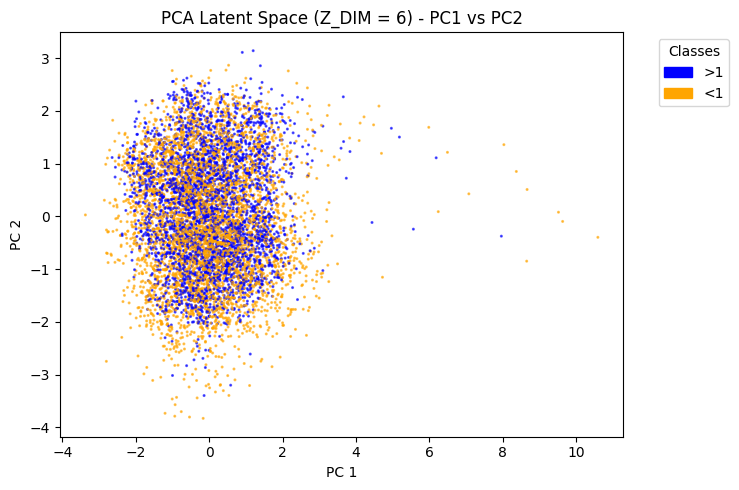

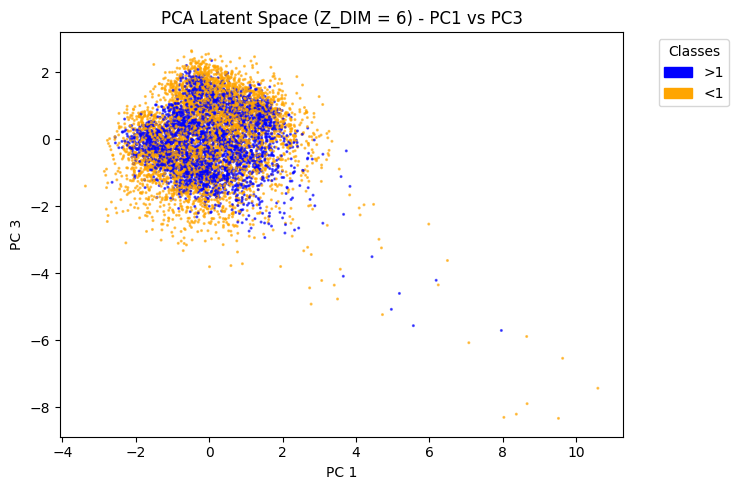

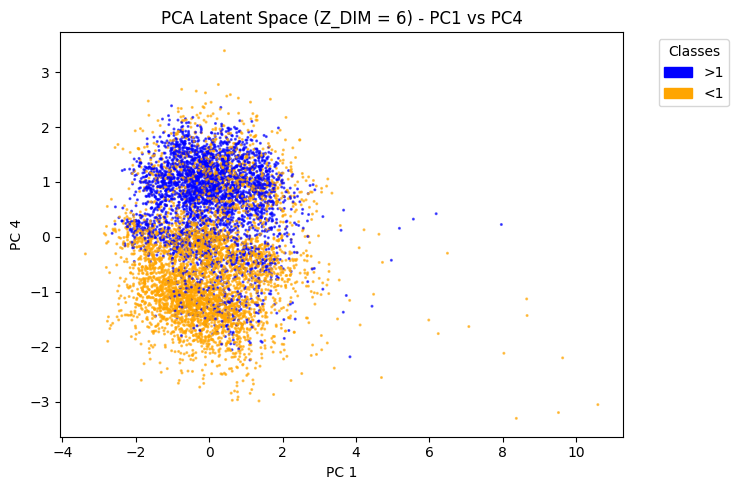

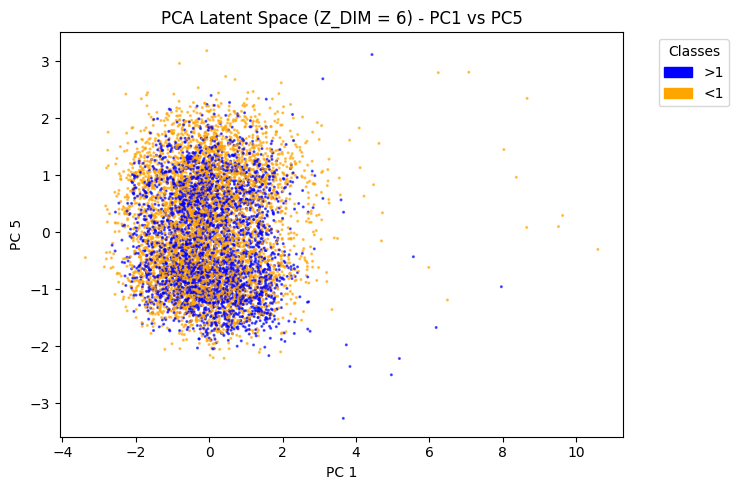

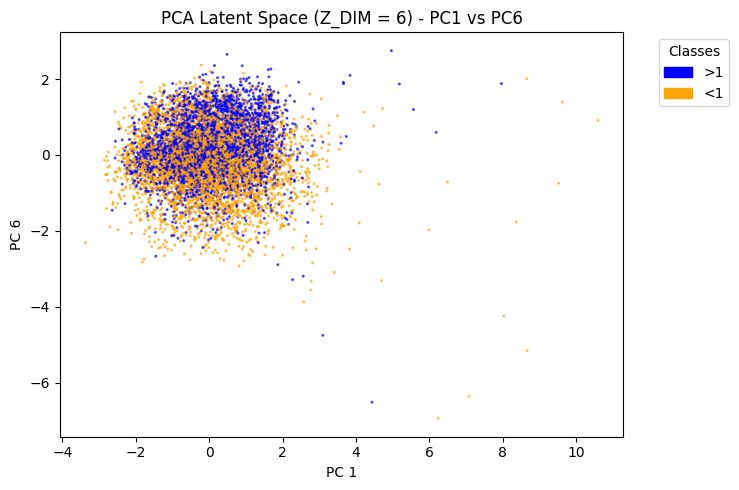

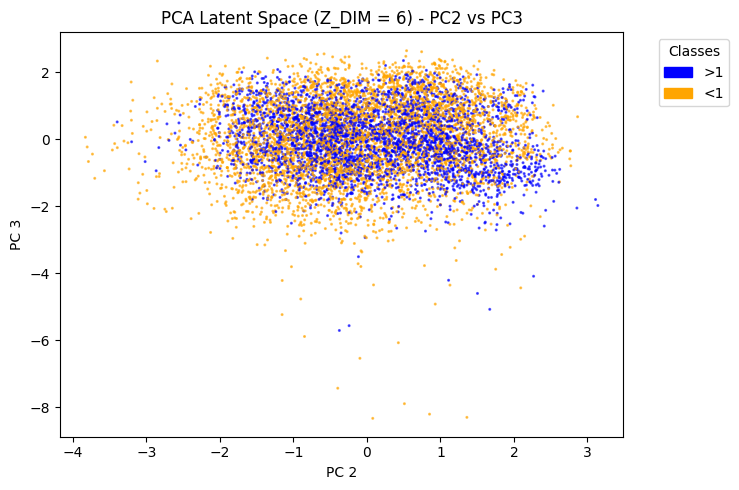

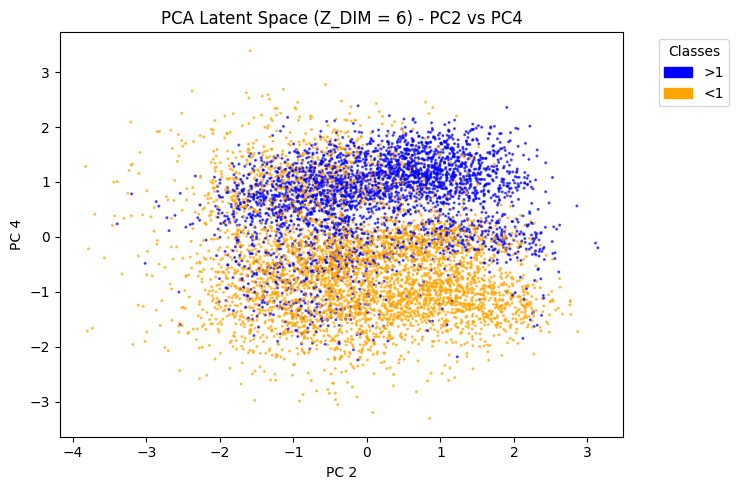

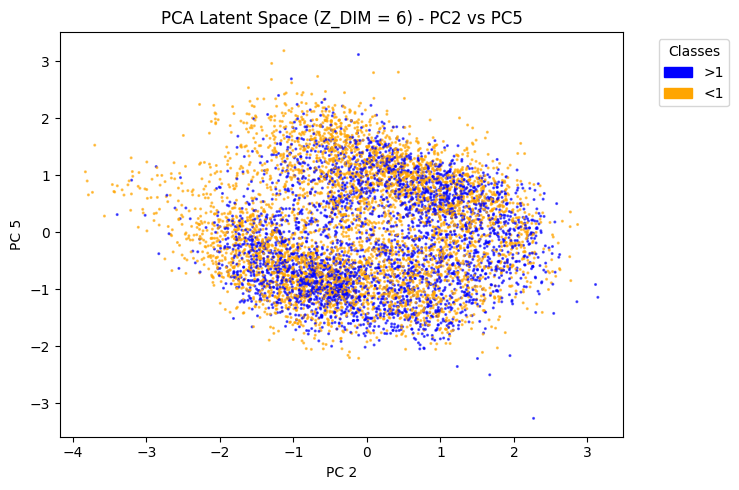

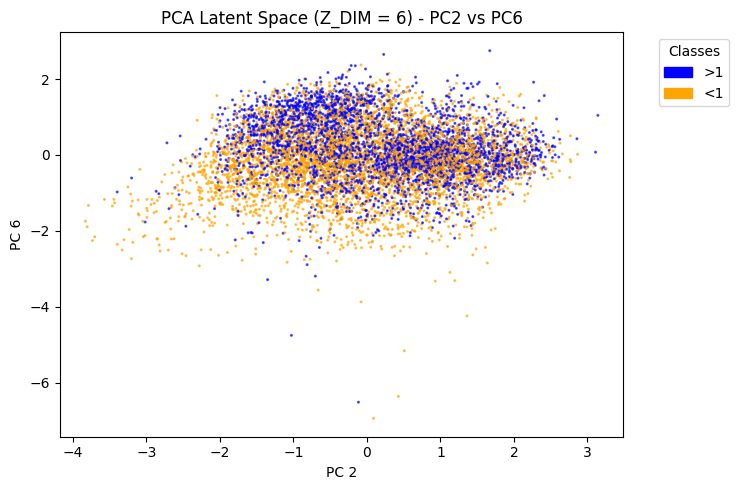

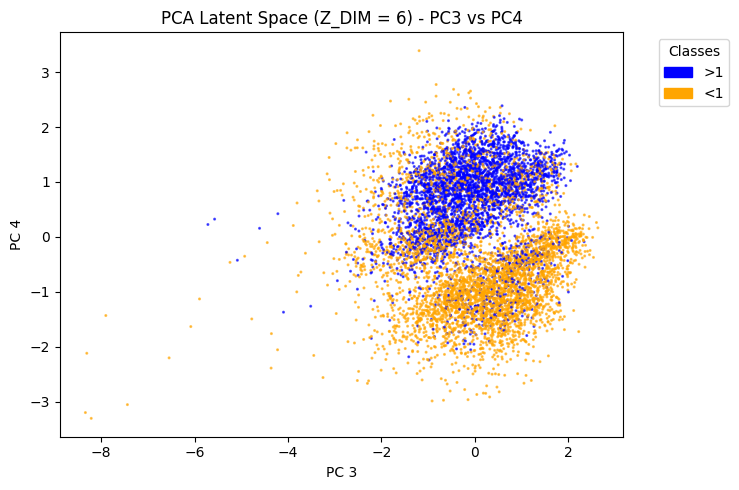

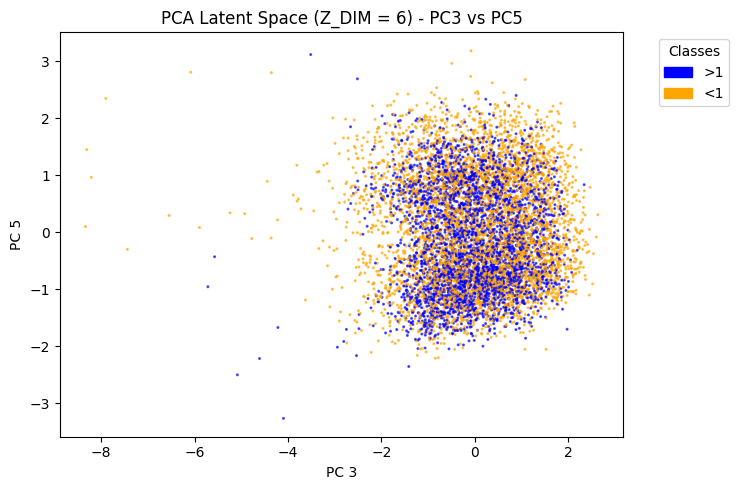

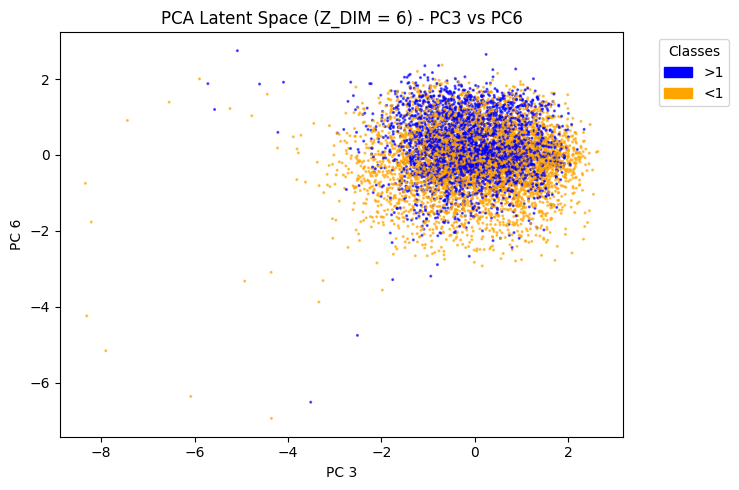

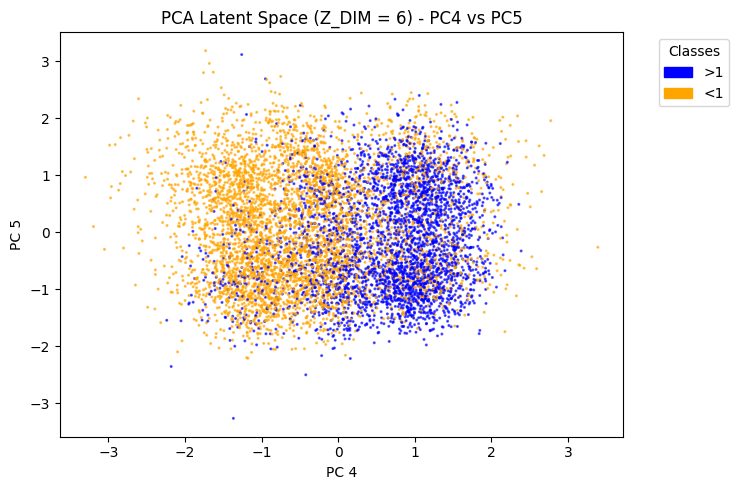

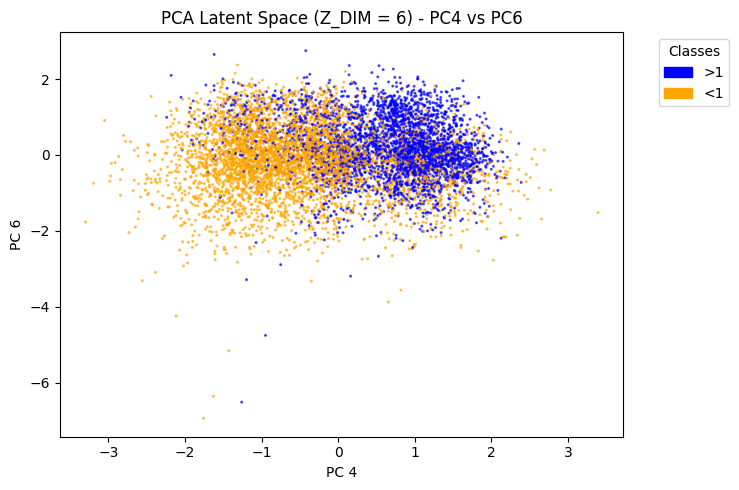

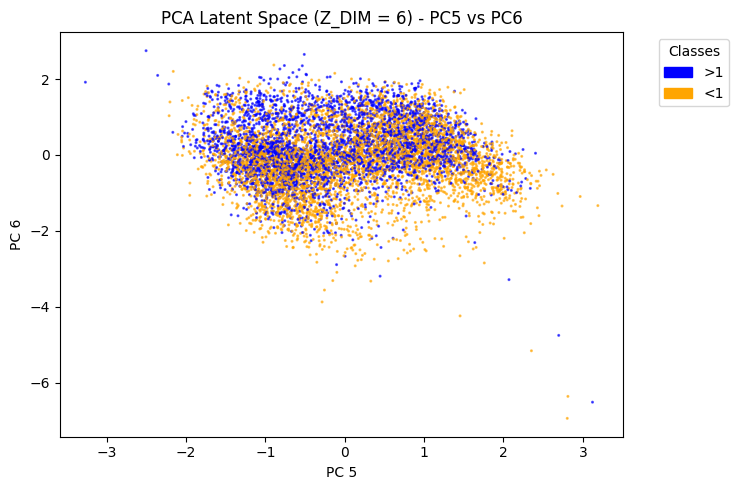

In [17]:

# get the latent vectors (test set)
zs = []
ts = []
reconstructed = []
original = []

model.eval()
with torch.no_grad():
    # train set
    for x_train, t, _ in train_loader:
        x_train = x_train.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_train)
        epsilon = torch.randn_like(sigma)
        
        # compute z via reparameterization trick
        z = mu + sigma * epsilon
        zs.append(z.cpu())  # vector
        ts.append(t)  # class information
        original.append(x_train.cpu().numpy())
        reconstructed.append(x_reconstructed.cpu().numpy())
        
    # validation set
    for x_val, t, _ in val_loader:
        x_val = x_val.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_val)
        epsilon = torch.randn_like(sigma)
        
        # compute z via reparameterization trick
        z = mu + sigma * epsilon
        zs.append(z.cpu())  # vector
        ts.append(t)  # class information
        original.append(x_val.cpu().numpy())
        reconstructed.append(x_reconstructed.cpu().numpy())

    # test set
    for x_test, t, _ in test_loader:
        x_test = x_test.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_test)
        epsilon = torch.randn_like(sigma)
        
        # compute z via reparameterization trick
        z = mu + sigma * epsilon
        zs.append(z.cpu())  # vector
        ts.append(t)  # class information
        original.append(x_test.cpu().numpy())
        reconstructed.append(x_reconstructed.cpu().numpy())

zs = torch.cat(zs, dim=0)  # (total_samples, latent_dim)
zs = zs.numpy()          # convert to numpy array
ts = torch.cat(ts, dim=0)
ts = ts.numpy()

pca = PCA(n_components = best_params['Z_DIM'])
zs_pca = pca.fit_transform(zs)
print('explained variance:',pca.explained_variance_ratio_)

print(np.shape(zs_pca))
plt.figure(figsize = (7.5, 5))


############################
# SOFIA
# qui ci sono un paio di cose che dovresti ritoccare per i plot
# colors handling
unique_ts = np.unique(ts)
# vengono usati solo i primi n colori (dove n numero di diverse categorie in timestamp
custom_colors = ['blue','orange', 'green','#006064','lightblue','#1B5E20', 'green', 'brown','orange','yellow','pink','red','#FFEB3B','#FAF4C4','#FAF4C4',]  
keep_colors = custom_colors[:len(unique_ts)]
custom_colormap = ListedColormap(custom_colors[:len(unique_ts)])
# legend
# qui dovresti scrivere a mano a che cosa corrisponde ogni categoria
# custom_labels = ['winter','spring','summer','autumn']
custom_labels = ['>1',
                 '<1']
#############################
legend_handles = [
    Patch(color=keep_colors[i], label=custom_labels[i]) for i in range(len(unique_ts))
]

# Plot all 2D combinations of PCA components
combinations = list(itertools.combinations(range(zs_pca.shape[1]), 2))
for i, (x_idx, y_idx) in enumerate(combinations):
    plt.figure(figsize=(7.5, 5))
    
    scatter = plt.scatter(zs_pca[:, x_idx], zs_pca[:, y_idx], c=ts, cmap=custom_colormap, s=1.4, alpha = 0.6)
    
    plt.title(f"PCA Latent Space (Z_DIM = {Z_DIM}) - PC{x_idx+1} vs PC{y_idx+1}")
    plt.xlabel(f"PC {x_idx+1}")
    plt.ylabel(f"PC {y_idx+1}")
    
    plt.legend(handles=legend_handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.colorbar(label='Generation trend')
    plt.tight_layout()
    
    filename = f'{directory_name}/part2.5_latent_space_pca_{x_idx}_{y_idx}.png'
    plt.savefig(filename)
    #plt.savefig(f"PCA_output/ZDIM_{Z_DIM}_PC{x_idx}_{y_idx}.png")
    plt.show()

## 2.6: reconstructing the input
Other than creating an efficient latent space for classification, a VAE must also be able to reconstruct the starting features from its latent space. We can visualize the results to check wheter this is true or not

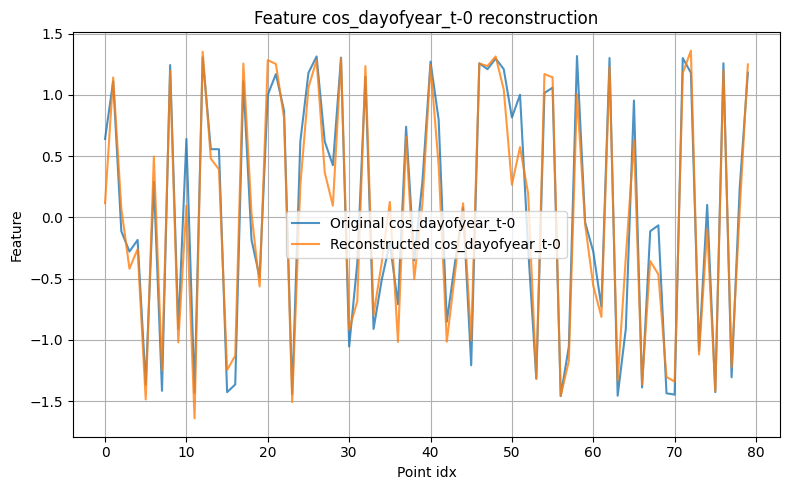

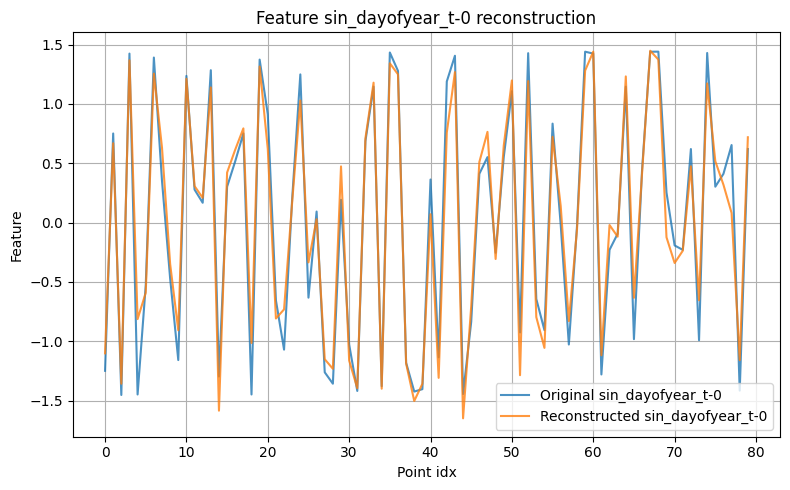

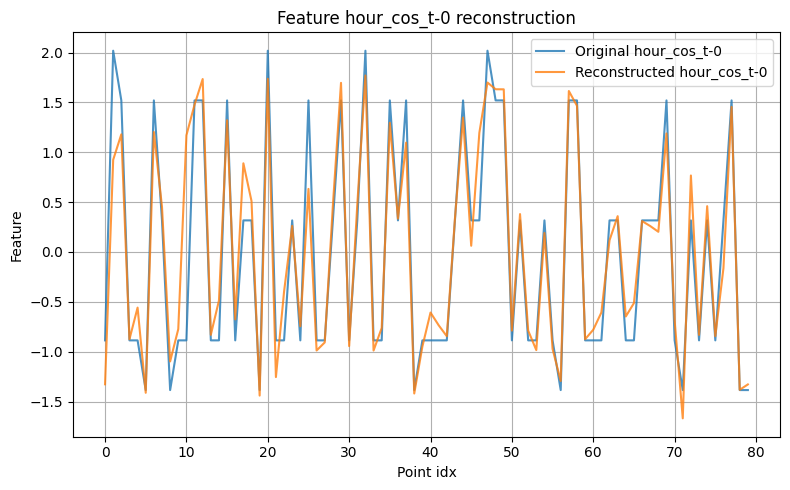

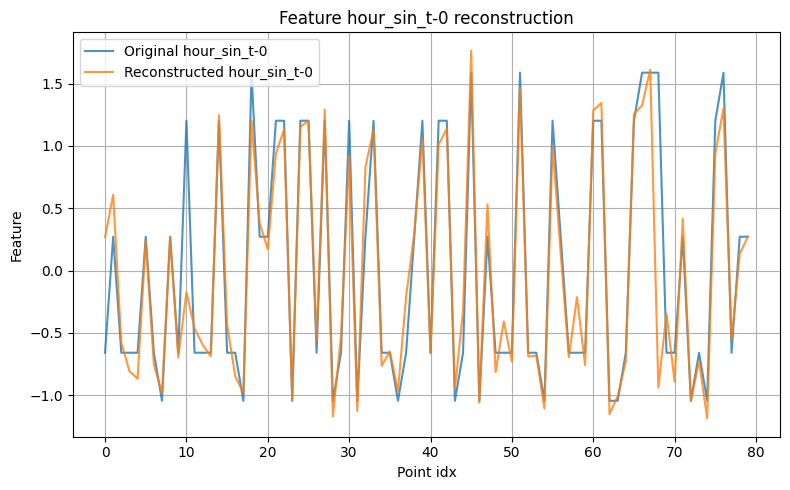

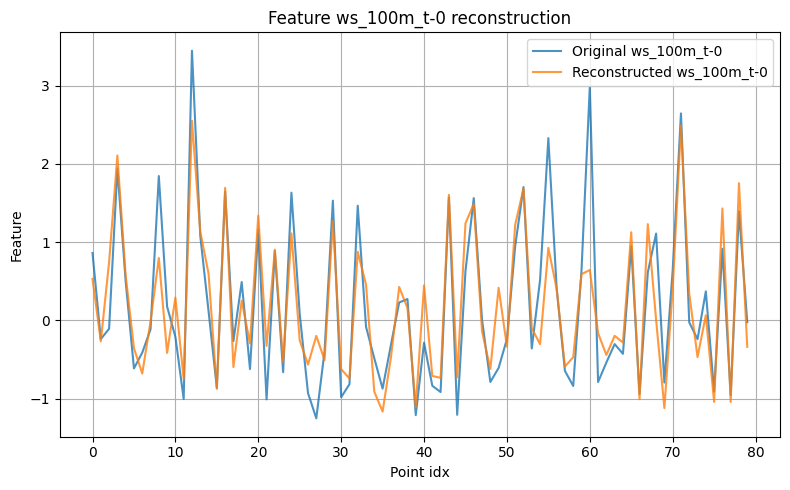

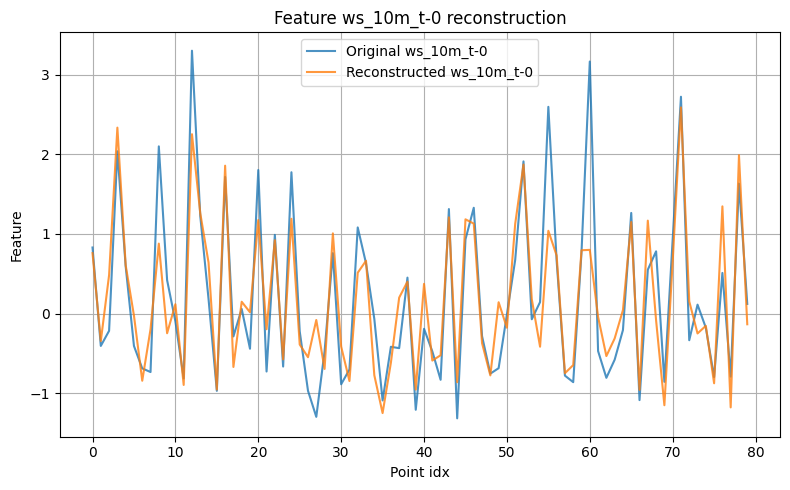

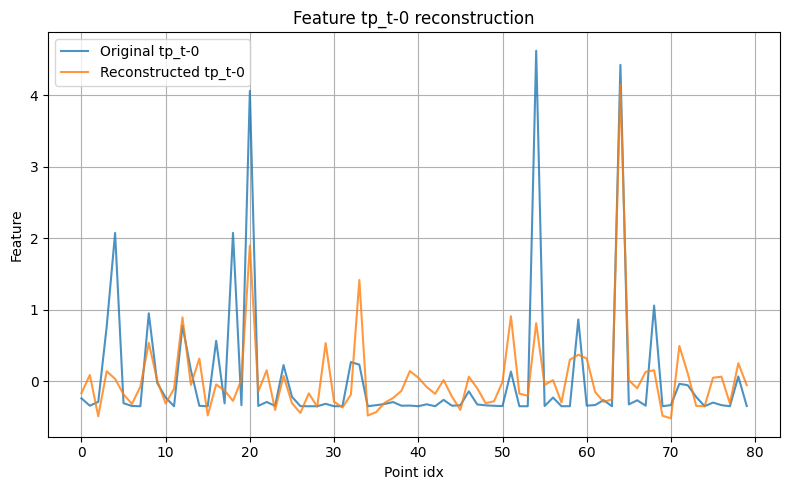

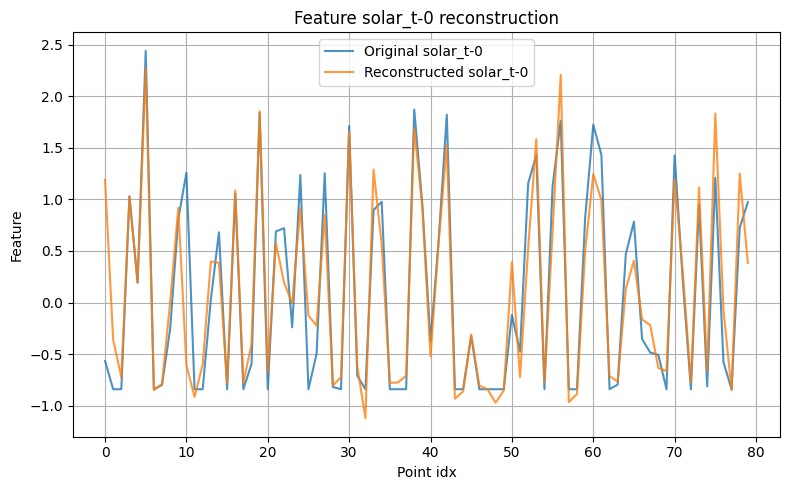

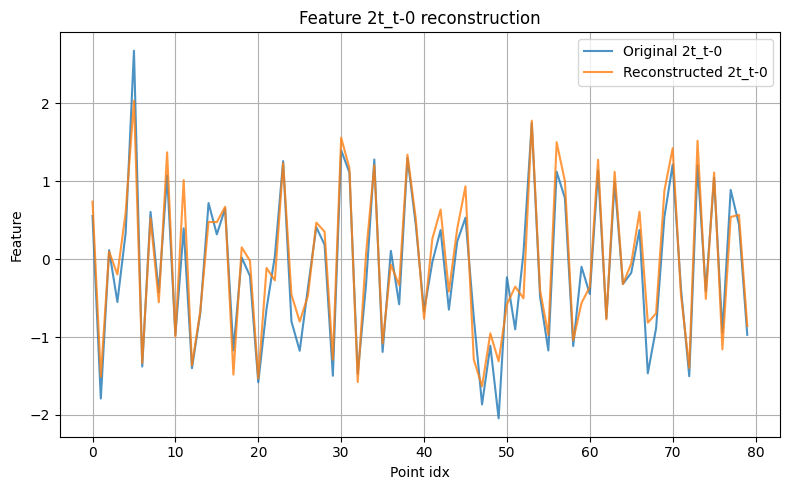

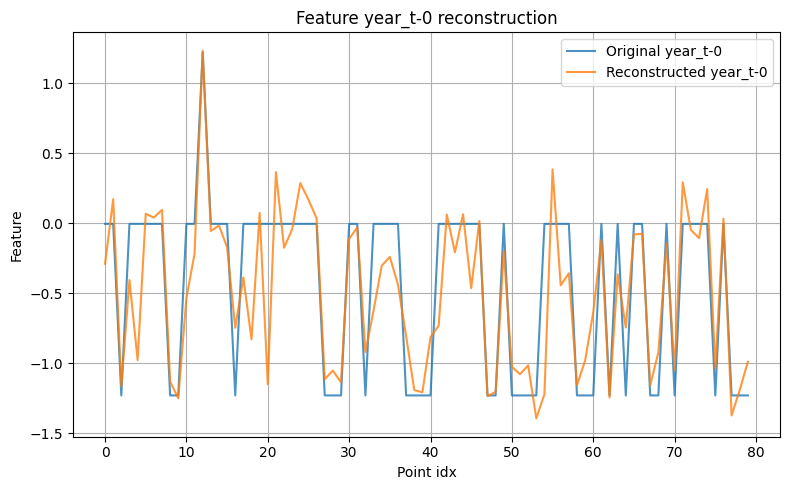

In [18]:
# concatenate all batches
original_all = np.concatenate(original, axis=0)       
reconstructed_all = np.concatenate(reconstructed, axis=0)
#print(np.shape(original_all),np.shape(reconstructed_all))
features_to_plot = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]
dummy_x = np.arange(0,np.shape(original_all)[0],1)
points_to_plot = 80

for feature_idx in features_to_plot:
    
    plt.figure(figsize=(8, 5))
    plt.plot(dummy_x[:points_to_plot],
                original_all[:, feature_idx][:points_to_plot],
                alpha=0.8, label=f'Original {features[feature_idx]}')
    plt.plot(dummy_x[:points_to_plot],
                reconstructed_all[:, feature_idx][:points_to_plot],
                alpha=0.8, label=f'Reconstructed {features[feature_idx]}')
    plt.xlabel("Point idx")
    plt.ylabel("Feature")
    plt.title(f"Feature {features[feature_idx]} reconstruction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    filename = f'{directory_name}/part2.6_feature_reconstruction_{feature_idx}.png'
    plt.savefig(filename)
    plt.show() 

## 2.7: Loss plot
A check on the performance can be done on the loss plot across the epochs: the trend must be generally decreasing, while the single components should 

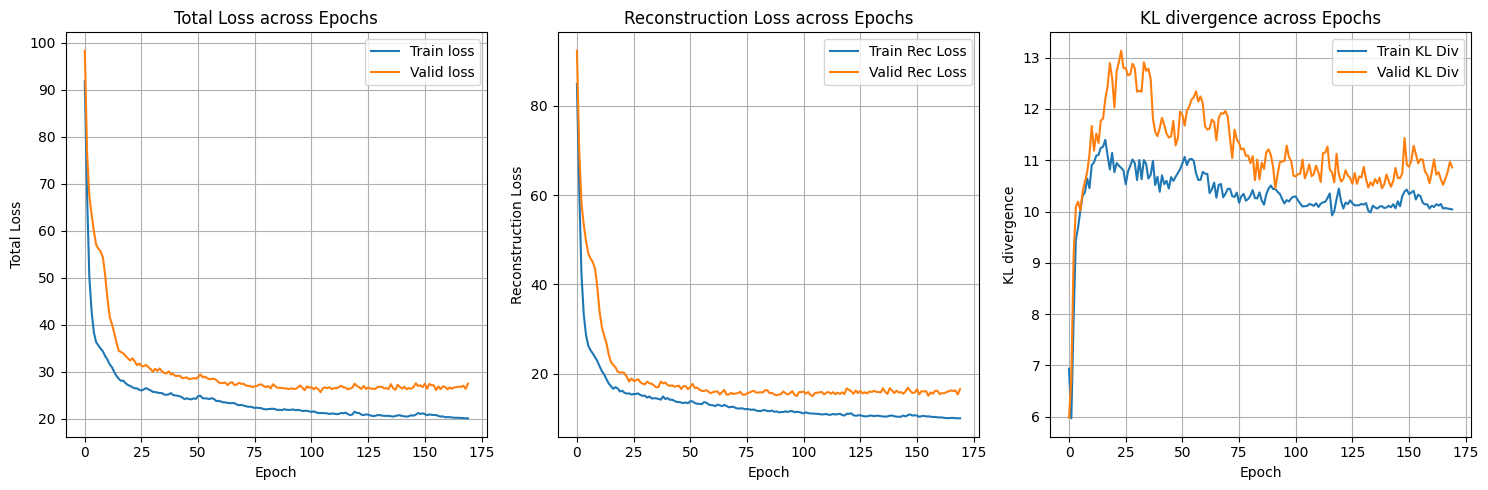

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
ymin, ymax = 0, 140

epochs = np.arange(0,NUM_EPOCHS ,1)
# Plot of Total Loss
axs[0].plot(epochs,history['total_loss'], label = 'Train loss')
axs[0].plot(epochs,history['val_total_loss'], label = 'Valid loss')
axs[0].set_ylabel("Total Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Total Loss across Epochs")
axs[0].legend()
axs[0].grid(True)

# Plot of Reconstruction Loss
axs[1].plot(epochs,history['reconstruction_loss'], label = 'Train Rec Loss')
axs[1].plot(epochs,history['val_reconstruction_loss'], label = 'Valid Rec Loss')
axs[1].set_ylabel("Reconstruction Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Reconstruction Loss across Epochs")
axs[1].legend()
axs[1].grid(True)

# Plot of KL Divergence
axs[2].plot(epochs,history['kl_div'], label = 'Train KL Div')
axs[2].plot(epochs,history['val_kl_div'], label = 'Valid KL Div')
axs[2].set_ylabel("KL divergence")
axs[2].set_xlabel("Epoch")
axs[2].set_title("KL divergence across Epochs")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
filename = f'{directory_name}/part2.7_losses.png'
plt.savefig(filename)
plt.show()

# 3: Attach a NN in tail of the VAE
After having trained the VAE, we freeze it and its structure and use it to compute the latent vectors correspondant to all of our records. The so obtained data has a reduced dimensionality which coincides with the dimension of the latent space. These, with features regarding the installation, are the inputs of the NN in charge of the classification
## 3.1 Model definition

In [20]:
class SimpleClassifier(nn.Module):
    def __init__(self, z_dim, x_extra_dim, hidden_dims, output_dim, dropout_prob = 0.3):
        super(SimpleClassifier, self).__init__()
        input_dim = z_dim + x_extra_dim

        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob) 

    def forward(self, zs, x_extra):
        #print('zs:', zs.shape, 'x_extra:', x_extra.shape)

        x = torch.cat((zs, x_extra), dim=1)  # concatenate along feature dimension
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.output(x)
        return logits

## 3.2: Data preparation
First off we need to compute the latent vectors of all of our inputs and standard scale them (installation features were already scaled above)

In [21]:
class CombinedDataset(Dataset):
    def __init__(self, zs_tensor, X_extra, Y):
        self.zs = zs_tensor
        self.X_extra = X_extra
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.zs[idx], self.X_extra[idx], self.Y[idx]

In [22]:
# compute all hidden vectors

model.eval()  # set to evaluation mode
device = 'cpu'
data_tensor = data_tensor.to(device)  # move input to same device as model

with torch.no_grad():
    mu, logvar = model.encode(data_tensor)
    zs = mu.cpu().numpy()

# save hidden vectors
print(np.shape(zs))
print(np.shape(df_labels))
hidden_vectors = zs

# scale the hidden vectors
scaler_z = StandardScaler()
scaler_z.fit(zs)
scaled_zs = scaler_z.transform(zs)

(7994, 6)
(7994, 6)


In [23]:
# trying a different approach on installation features
'''df_labels['scaled_solar_installed'] = df_labels['scaled_solar_installed'] / (df_labels['scaled_solar_installed'] + df_labels['scaled_wind_installed'] + df_labels['scaled_hydro_installed'])
df_labels['scaled_wind_installed'] = df_labels['scaled_wind_installed'] / (df_labels['scaled_solar_installed'] + df_labels['scaled_wind_installed'] + df_labels['scaled_hydro_installed'])
df_labels['scaled_hydro_installed'] = df_labels['scaled_hydro_installed'] / (df_labels['scaled_solar_installed'] + df_labels['scaled_wind_installed'] + df_labels['scaled_hydro_installed'])
'''
# take inputs and make them torch tensors
X_extra = torch.tensor(df_labels[['scaled_solar_installed','scaled_hydro_installed','scaled_wind_installed']].values, dtype=torch.float32)
Y = torch.tensor(df_labels['class'].values, dtype=torch.long)  # this is the classification target

# check the classes
print('All different classes:',torch.unique(Y))

# check the latent vector tensor
if isinstance(zs, np.ndarray):
    zs_tensor = torch.tensor(scaled_zs, dtype=torch.float32)
else:
    zs_tensor = scaled_zs  # already a tensor

# divide the dataset (70% training 15% validation 15% test set)
full_dataset = CombinedDataset(zs_tensor, X_extra, Y)
indices = list(range(total_size))
train_dataset = Subset(full_dataset, indices[:train_end])
val_dataset = Subset(full_dataset, indices[train_end:val_end])
test_dataset = Subset(full_dataset, indices[val_end:])

print('zs_tensor shape:', zs_tensor.shape)       # e.g. (N, z_dim)
print('X_extra shape:', X_extra.shape)     

z_dim = zs_tensor.shape[1]
x_extra_dim = X_extra.shape[1]


All different classes: tensor([0, 1])
zs_tensor shape: torch.Size([7994, 6])
X_extra shape: torch.Size([7994, 3])


## 3.3: balancing the classes
Since our classes could be unbalanced, to prevent the NN to be biased towards the majority class, we throw a balancing weight parameter according to the distributions of the classes

In [24]:
def class_distribution(subset):
    labels = [subset[i][2].item() for i in range(len(subset))]
    return np.bincount(labels)

print("Train class distribution:", class_distribution(train_dataset))
print("Val class distribution:", class_distribution(val_dataset))
print("Test class distribution:", class_distribution(test_dataset))


Train class distribution: [2426 3169]
Val class distribution: [415 784]
Test class distribution: [506 694]


In [25]:
# Get unique class labels and compute weights
class_labels = np.unique(Y.numpy())
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=Y.numpy())
weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", weights)


Class weights: tensor([1.1942, 0.8601])


## 3.4: training the NN
As done for the VAE, we run a grid search on the hyperparameters space to retrieve the best configuration of the NN

In [26]:
device = 'cpu'

num_epochs = 50
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the search space
param_grid = {
    'hidden_dims': [[64, 32], [32,16], [16,8], [8,4]],
    'lr': [1e-4, 1e-3],
    'batch_size': [64, 128],
    'weight_decay': [1e-2,1e-3,1e-4],
    'dropout_prob': [0.05,0.15,0.3] 
}

# Create all combinations of parameters
param_combinations = list(product(*param_grid.values()))

correct = 0
total = 0
# Best tracking
best_val_accuracy = 0.0
best_model = None
best_params = None

# Grid search loop
for params in tqdm(param_combinations, desc="Grid Search"):
    hidden_dims, lr, batch_size, weight_decay, dropout_prob = params
    print(f"\nTraining with: hidden_dims={hidden_dims}, lr={lr}, batch_size={batch_size}, weight_decay={weight_decay}, dropout_prob={dropout_prob}")

    # Update loaders with batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, optimizer
    modelNN = SimpleClassifier(z_dim = z_dim,
                               x_extra_dim = x_extra_dim,
                               hidden_dims=hidden_dims,
                               output_dim=len(torch.unique(Y))+1,
                               dropout_prob=dropout_prob
                              ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelNN.parameters(), lr=lr, weight_decay = weight_decay)

    # Training
    for epoch in range(num_epochs):
        modelNN.train()
        for zs, x_extra, labels in train_loader:
            zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = modelNN(zs, x_extra)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

    # Validation
    modelNN.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for zs, x_extra, labels in val_loader:
            zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
            logits = modelNN(zs, x_extra)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save best
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = modelNN
        best_params = {
            'hidden_dims': hidden_dims,
            'lr': lr,
            'batch_size': batch_size,
            'weight_decay': weight_decay,
            'dropout_prob': dropout_prob
        }

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

Grid Search:   0%|          | 0/144 [00:00<?, ?it/s]


Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.01, dropout_prob=0.05
Validation Accuracy: 86.49%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.01, dropout_prob=0.15
Validation Accuracy: 86.07%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.01, dropout_prob=0.3
Validation Accuracy: 85.99%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.001, dropout_prob=0.05
Validation Accuracy: 84.74%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.001, dropout_prob=0.15
Validation Accuracy: 85.65%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.001, dropout_prob=0.3
Validation Accuracy: 84.99%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.0001, dropout_prob=0.05
Validation Accuracy: 86.16%

Training with: hidden_dims=[64, 32], lr=0.0001, batch_size=64, weight_decay=0.0001, dropout_p

## 3.5: Retraining with best parameters

Training Epochs:   0%|          | 0/150 [00:00<?, ?it/s]


Final Validation Accuracy: 86.16%


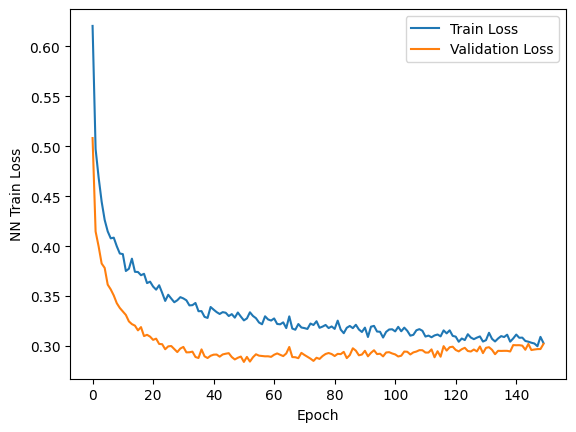

In [39]:
num_epochs = 150
hidden_dims = best_params['hidden_dims']
lr = best_params['lr'] 
batch_size = best_params['batch_size']
weight_decay = best_params['weight_decay']
dropout_prob = best_params['dropout_prob']


train_dataset = Subset(full_dataset, indices[:train_end])
val_dataset = Subset(full_dataset, indices[train_end:val_end])
test_dataset = Subset(full_dataset, indices[val_end:])

modelNN = SimpleClassifier(z_dim = z_dim,
                               x_extra_dim = x_extra_dim,
                               hidden_dims=hidden_dims,
                               output_dim=len(torch.unique(Y)),
                               dropout_prob=dropout_prob
                              ).to(device)

criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = optim.Adam(modelNN.parameters(), lr=lr)

# Update loaders with batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

NNlosses = []
val_losses = []

epoch_bar = tqdm(range(num_epochs), desc="Training Epochs")

for epoch in epoch_bar:
    modelNN.train()
    epoch_loss = 0.0

    for zs, x_extra, labels in train_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = modelNN(zs, x_extra)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * zs.size(0)

    avg_train_loss = epoch_loss / len(train_loader.dataset)
    NNlosses.append(avg_train_loss)

    # Validation loss
    modelNN.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for zs, x_extra, labels in val_loader:
            zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
            logits = modelNN(zs, x_extra)
            loss = criterion(logits, labels)

            val_loss += loss.item() * zs.size(0)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    epoch_bar.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss, val_acc=val_accuracy)

print(f"\nFinal Validation Accuracy: {val_accuracy:.2f}%")

plt.plot(np.arange(0,num_epochs,1),NNlosses, label = 'Train Loss')
plt.plot(np.arange(0,num_epochs,1),val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('NN Train Loss')
plt.legend()
filename = f'{directory_name}/part3.5_NN_loss.png'
plt.savefig(filename)
plt.show()

# 4: Results visualization

## 4.1: Time-aware accuracy
One of the main goals of our project is to get a working classifier which performance must be generally decreasing in time (since the past is more far away), but hopefully without any drastic drops at any time. A rapid fall in accuracy means that the model is not able to identify specific patterns in the data and fails to interpret them correctly.

In [40]:
def accuracy_score(y_true, y_pred):
    """
    Compute the classification accuracy.

    Parameters:
    - y_true: true labels (1D array-like or tensor)
    - y_pred: predicted labels (1D array-like or tensor)

    Returns:
    - accuracy: float (percentage of correct predictions)
    """
    # Convert to numpy if they are torch tensors
    if hasattr(y_true, 'detach'):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    correct = (y_true == y_pred).sum()
    total = len(y_true)
    return correct / total

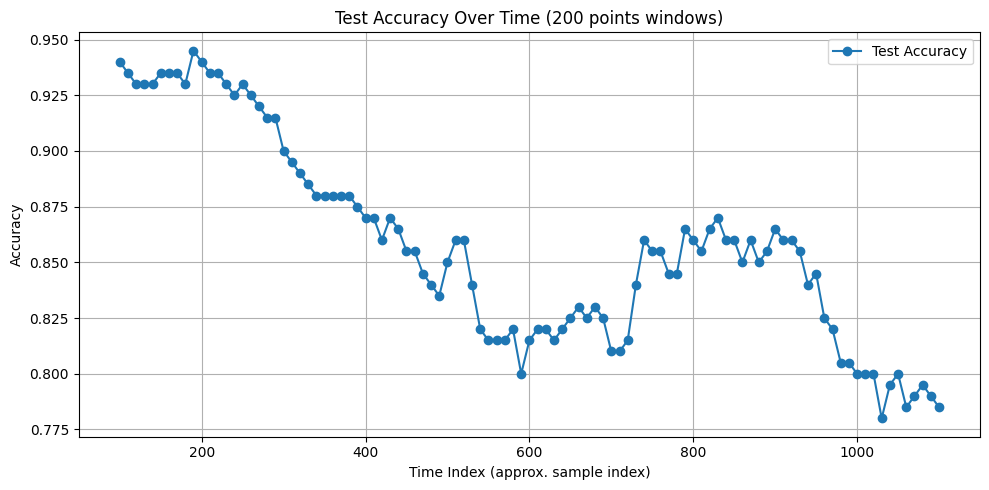

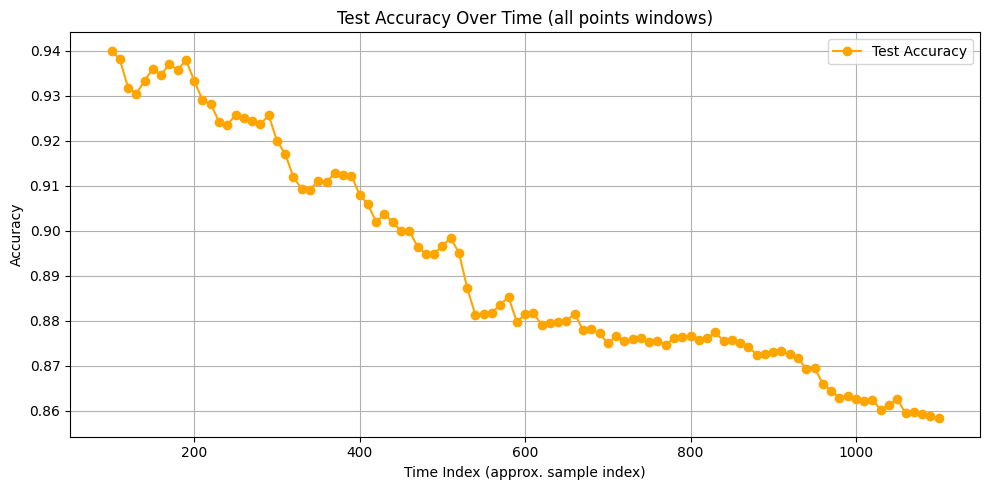

In [41]:
modelNN.eval()  # Set model to eval mode
accuracies = []
time_indices = []

window_preds = []
window_labels = []
window_size = 200  # Adjust as needed
step_size = 10

index = 0

# Collect all validation data in order
all_preds = []
all_labels = []


with torch.no_grad():
    for zs, x_extra, labels in test_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)

        outputs = modelNN(zs, x_extra)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now slide over the predictions and calculate accuracy
num_samples = len(all_preds)

for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size
    preds_slice = all_preds[start:end]
    labels_slice = all_labels[start:end]

    acc = accuracy_score(labels_slice, preds_slice)
    accuracies.append(acc)
    time_indices.append(start + window_size // 2)  # midpoint

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_indices, accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Time Index (approx. sample index)")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Time (200 points windows)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

accuracies = []
time_indices = []
for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size
    preds_slice = all_preds[0:end]
    labels_slice = all_labels[0:end]

    acc = accuracy_score(labels_slice, preds_slice)
    accuracies.append(acc)
    time_indices.append(start + window_size // 2)  # midpoint

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_indices, accuracies, marker='o', label='Test Accuracy', color = 'orange')
plt.xlabel("Time Index (approx. sample index)")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Time (all points windows)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 4.2: Confusion matrices
Another check on performance can be done by computing the confusion matrices. Let's do this for all sets

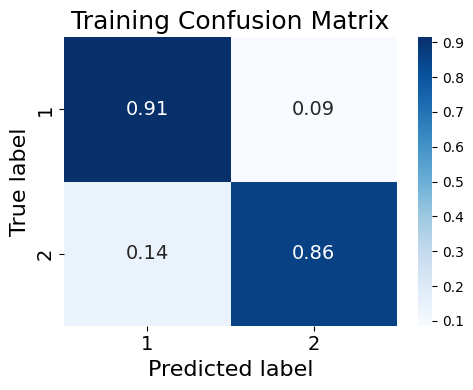

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2426
           1       0.93      0.86      0.89      3169

    accuracy                           0.88      5595
   macro avg       0.88      0.89      0.88      5595
weighted avg       0.89      0.88      0.88      5595



In [42]:
modelNN.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for zs, x_extra, labels in train_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
        logits = modelNN(zs, x_extra)
        _, predicted = torch.max(logits.data, 1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # Font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('Training Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part4.2_corr_matrix_training.png'
plt.savefig(filename)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

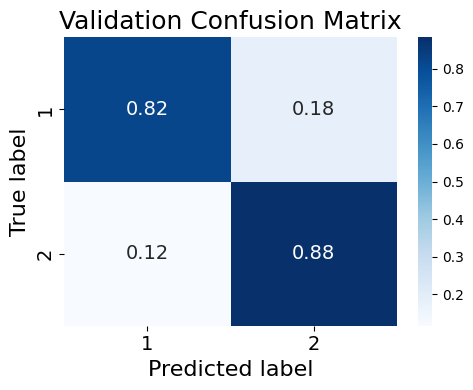

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       415
           1       0.90      0.88      0.89       784

    accuracy                           0.86      1199
   macro avg       0.85      0.85      0.85      1199
weighted avg       0.86      0.86      0.86      1199



In [43]:
modelNN.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for zs, x_extra, labels in val_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
        logits = modelNN(zs, x_extra)
        _, predicted = torch.max(logits.data, 1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # Font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('Validation Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part4.2_corr_matrix_validation.png'
plt.savefig(filename)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

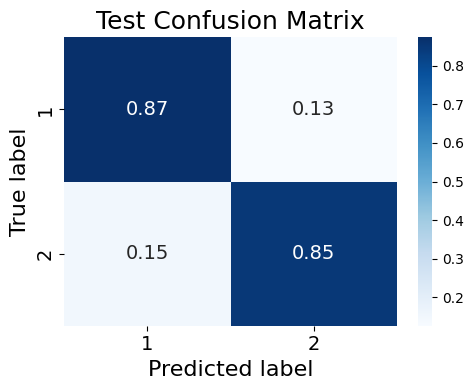

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       506
           1       0.90      0.85      0.87       694

    accuracy                           0.86      1200
   macro avg       0.85      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200



In [44]:
modelNN.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for zs, x_extra, labels in test_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
        logits = modelNN(zs, x_extra)
        _, predicted = torch.max(logits.data, 1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # Font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('Test Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part4.2_corr_matrix_test.png'
plt.savefig(filename)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

## 4.3 ROC Curve
Another interesting metric for evaluating the performance of the model is the ROC curve. The higher the area under the curve, the better is the model in interpreting the classes 

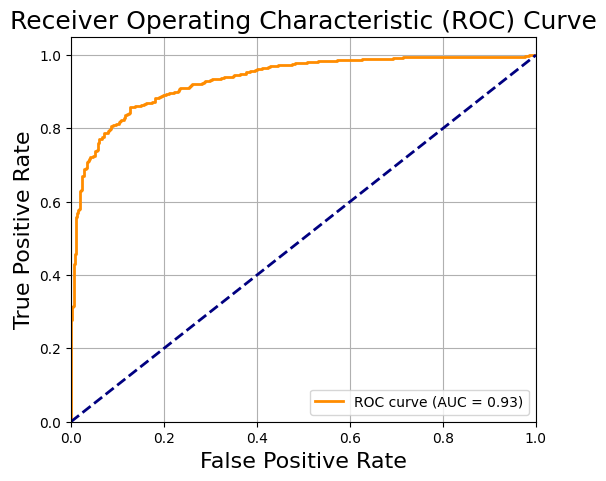

In [45]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 18)
plt.legend(loc="lower right")
plt.grid(True)
filename = f'{directory_name}/part4.3_ROC.png'
plt.savefig(filename)
plt.show()
